In [4]:
# import libraries and the dataset.

import numpy as np
import pandas as pd
from nltk.tokenize.regexp import RegexpTokenizer
from nltk.corpus import stopwords
from gensim.models import Word2Vec, KeyedVectors
from scipy.spatial.distance import cosine
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk')

In [2]:
# Working on sample toy dataset from Eligijus112’s repository with permissions.
text = ["The prince is the future king.",
"Daughter is the princess.",
"Son is the prince.",
"Only a man can be a king.",
"Only a woman can be a queen.",
"The princess will be a queen.",
"Queen and king rule the realm.",
"The prince is a strong man.",
"The princess is a beautiful woman.",
"The royal family is the king and queen and their children.",
"Prince is only a boy now.",
"A boy will be a man."]

In [6]:
# create a function that lowercases text, tokenises the documents into alphabetic tokens and removes stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def preprocess_text(document):
    tokeniser = RegexpTokenizer(r"[A-Za-z]{2,}")
    tokens = tokeniser.tokenize(document.lower())
    key_tokens = [token for token in tokens
    if token not in stopwords.words('english')]
    return key_tokens
corpus = []
for document in text:
    corpus.append(preprocess_text(document))
corpus


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[['prince', 'future', 'king'],
 ['daughter', 'princess'],
 ['son', 'prince'],
 ['man', 'king'],
 ['woman', 'queen'],
 ['princess', 'queen'],
 ['queen', 'king', 'rule', 'realm'],
 ['prince', 'strong', 'man'],
 ['princess', 'beautiful', 'woman'],
 ['royal', 'family', 'king', 'queen', 'children'],
 ['prince', 'boy'],
 ['boy', 'man']]

In [7]:
# Build Word2Vec using Gensim on our custom corpus
dimension = 2
window = 2
word2vec0 = Word2Vec(corpus, min_count=1, vector_size=dimension, window=window, sg=1)
word2vec0.wv.get_vector('king')

array([0.25516748, 0.45046365], dtype=float32)

In [8]:
# We will pick a sample word: 'king' and see if the words that are most similar to it in the vector space.

n=3
word2vec0.wv.most_similar(positive=['king'], topn=n)

[('man', 0.9941185116767883),
 ('realm', 0.9008388519287109),
 ('son', 0.7788276076316833)]

In [9]:
# Prepare a DataFrame of the embeddings for the vocabulary

embedding0 = pd.DataFrame(columns=['d0', 'd1'])
for token in word2vec0.wv.index_to_key:
  embedding0.loc[token] = word2vec0.wv.get_vector(token)
embedding0


,d0,d1
queen,-0.026811,0.011822
king,0.255167,0.450464
prince,-0.465198,-0.355929
man,0.322944,0.448649
princess,-0.250771,-0.188169
woman,0.369025,-0.076674
boy,-0.226831,0.327703
royal,-0.243008,-0.090801
beautiful,0.143829,0.049594
strong,-0.414221,-0.472374


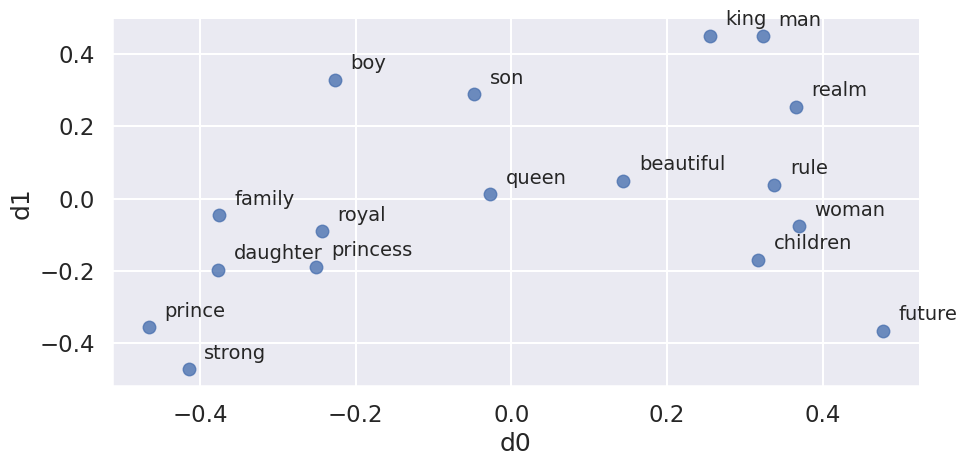

In [10]:
# Visualise the tokens in two-dimensional vector space:
sns.lmplot(data=embedding0, x='d0', y='d1', fit_reg=False, aspect=2)
for token, vector in embedding0.iterrows():
    plt.gca().text(vector['d0']+.02, vector['d1']+.03, str(token),
                   size=14)
plt.tight_layout()

In [11]:
# Manual Word2Vec — Approach 1

# Finding the vocabulary from the corpus

vocabulary = sorted([*set([token for document in corpus for token in
                           document])])
n_vocabulary = len(vocabulary)
token_index ={token: i for i, token in enumerate(vocabulary)}
token_index

{'beautiful': 0,
 'boy': 1,
 'children': 2,
 'daughter': 3,
 'family': 4,
 'future': 5,
 'king': 6,
 'man': 7,
 'prince': 8,
 'princess': 9,
 'queen': 10,
 'realm': 11,
 'royal': 12,
 'rule': 13,
 'son': 14,
 'strong': 15,
 'woman': 16}

In [12]:
token_pairs = []

In [13]:
for document in corpus:
    for i, token in enumerate(document):
        for j in range(i-window, i+window+1):
            if (j>=0) and (j!=i) and (j<len(document)):
                token_pairs.append([token] + [document[j]])

In [14]:
n_token_pairs = len(token_pairs)
print(f"{n_token_pairs} token pairs")

56 token pairs


In [15]:
# Token pairs are ready but they are still in text form
token_pairs[:5]

[['prince', 'future'],
 ['prince', 'king'],
 ['future', 'prince'],
 ['future', 'king'],
 ['king', 'prince']]

In [16]:
# One-hot-encode them to make them suitable for the neural network
X = np.zeros((n_token_pairs, n_vocabulary))
Y = np.zeros((n_token_pairs, n_vocabulary))

In [17]:
for i, (focus_token, context_token) in enumerate(token_pairs):
    X[i, token_index[focus_token]] = 1
    Y[i, token_index[context_token]] = 1
print(X[:5])

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [18]:
# Neural network with a single hidden layer

tf.random.set_seed(42)
word2vec1 = Sequential([
    Dense(units=dimension, input_shape=(n_vocabulary,),
          use_bias=False, name='embedding'),
    Dense(units=n_vocabulary, activation='softmax', name='output')
])
word2vec1.compile(loss='categorical_crossentropy', optimizer='adam')
word2vec1.fit(x=X, y=Y, epochs=100)

Epoch 1/100
2/2 [==============================] - 1s 11ms/step - loss: 2.8375
Epoch 2/100
2/2 [==============================] - 0s 8ms/step - loss: 2.8357
Epoch 3/100
2/2 [==============================] - 0s 8ms/step - loss: 2.8343
Epoch 4/100
2/2 [==============================] - 0s 12ms/step - loss: 2.8328
Epoch 5/100
2/2 [==============================] - 0s 7ms/step - loss: 2.8313
Epoch 6/100
2/2 [==============================] - 0s 7ms/step - loss: 2.8298
Epoch 7/100
2/2 [==============================] - 0s 8ms/step - loss: 2.8284
Epoch 8/100
2/2 [==============================] - 0s 9ms/step - loss: 2.8270
Epoch 9/100
2/2 [==============================] - 0s 7ms/step - loss: 2.8256
Epoch 10/100
2/2 [==============================] - 0s 8ms/step - loss: 2.8241
Epoch 11/100
2/2 [==============================] - 0s 7ms/step - loss: 2.8227
Epoch 12/100
2/2 [==============================] - 0s 8ms/step - loss: 2.8212
Epoch 13/100
2/2 [==============================] - 0s 7ms/

In [ ]:
# We specified hidden layer to have no bias terms.
# Since we want the hidden layer to have linear activation, we didn’t need to specify.
# The number of units in the layer reflects the size of the vector: dimension.

In [19]:
# Extract the weights, our embeddings, from the hidden layer
embedding1 = pd.DataFrame(columns=['d0', 'd1'])
for token in token_index.keys():
    ind = token_index[token]
    embedding1.loc[token] = word2vec1.get_weights()[0][ind]
embedding1

,d0,d1
beautiful,0.245183,-0.112004
boy,-0.228860,-0.606346
children,0.638681,0.076331
daughter,-0.242534,0.294414
family,0.615521,0.025868
future,-0.199089,-0.153760
king,0.283226,0.463066
man,-0.103712,-0.217158
prince,-0.651151,0.066690
princess,0.151123,-0.274800


In [20]:
# See the most similar 3 words to 'king'
vector1 = embedding1.loc['king']
similarities = {}

In [21]:
for token, vector in embedding1.iterrows():
    theta_sum = np.dot(vector1, vector)
    theta_den = np.linalg.norm(vector1) * np.linalg.norm(vector)
    similarities[token] = theta_sum / theta_den

In [22]:
similar_tokens = sorted(similarities.items(), key=lambda x: x[1],
                        reverse=True)
similar_tokens[1:n+1]

[('queen', 0.99984133), ('royal', 0.9592773), ('son', 0.7094242)]

In [23]:
# Save the embeddings and load them using Gensim.

with open('embedding1.txt' ,'w') as text_file:
    text_file.write(f'{n_vocabulary} {dimension}\n')
    for token, vector in embedding1.iterrows():
        text_file.write(f"{token} {' '.join(map(str, vector))}\n")
text_file.close()

In [24]:
embedding1_loaded = KeyedVectors.load_word2vec_format('embedding1.txt', binary=False)
embedding1_loaded.most_similar(positive=['king'], topn=n)

[('queen', 0.9998413920402527),
 ('royal', 0.9592772126197815),
 ('son', 0.7094241380691528)]

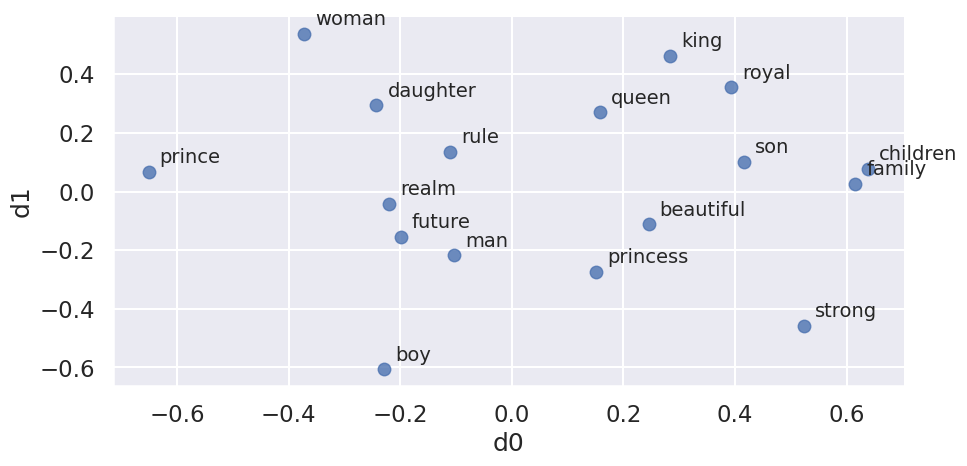

In [25]:
# Visualise the embeddings in the vector space
sns.lmplot(data=embedding1, x='d0', y='d1', fit_reg=False, aspect=2)
for token, vector in embedding1.iterrows():
    plt.gca().text(vector['d0']+.02, vector['d1']+.03, str(token),
                   size=14)
plt.tight_layout()

In [26]:
# Manual Word2Vec — Approach 2

# Creating a class called Data which centralises data-related tasks

class Data():
    def __init__(self, text):
        self.text = text
        self.corpus = self.extract_corpus()

    def preprocess_text(self, document):
        tokeniser = RegexpTokenizer(r"[A-Za-z]{2,}")
        tokens = tokeniser.tokenize(document.lower())
        key_tokens = [token for token in tokens if token not in stopwords.words('english')]
        return key_tokens

    def extract_corpus(self):
        corpus = []
        for document in self.text:
            corpus.append(self.preprocess_text(document))
        return corpus

    def one_hot_encode(self, token):
        ohe_vector = np.zeros(self.n_vocabulary)
        ohe_vector[self.token_index[token]] = 1
        return ohe_vector

    def prepare_focus_context_data(self, window=2):
        self.window = window
        self.vocabulary = sorted([*set([token for document in self.corpus for token in document])])
        self.n_vocabulary = len(self.vocabulary)
        self.token_index ={token: i for i, token in enumerate(self.vocabulary)}
        self.index_token = {i: token for token, i in self.token_index.items()}

        self.focus_context_data = []
        for sentence in self.corpus:
            for i, token in enumerate(sentence):
                focus_token = self.one_hot_encode(token)
                context_tokens = []
                for j in range(i-window, i+window+1):
                    if (j!=i) and (j<=len(sentence)-1) and (j>=0):
                        context_tokens.append(self.one_hot_encode(sentence[j]))
                self.focus_context_data.append((focus_token, context_tokens))

data = Data(text)
data.prepare_focus_context_data()
data.corpus

[['prince', 'future', 'king'],
 ['daughter', 'princess'],
 ['son', 'prince'],
 ['man', 'king'],
 ['woman', 'queen'],
 ['princess', 'queen'],
 ['queen', 'king', 'rule', 'realm'],
 ['prince', 'strong', 'man'],
 ['princess', 'beautiful', 'woman'],
 ['royal', 'family', 'king', 'queen', 'children'],
 ['prince', 'boy'],
 ['boy', 'man']]

In [27]:
# We can see that the corpus attribute looks the same as in earlier sections.

len([token for document in data.corpus for token in document])

32

In [28]:
# There are 32 tokens in our toy corpus.

len(data.focus_context_data)


32

In [29]:
# Each of these 32 tokens have been mapped together with all of their context tokens.
np.sum([len(context_tokens) for _, context_tokens in
        data.focus_context_data])

56

In [30]:
# Centralise the code regarding Word2Vec in an object
class Word2Vec():
    def __init__(self, dimension):
        self.dimension = dimension

    def train(self, data, learning_rate, epochs, seed=24):
        self.data = data
        np.random.seed(seed)
        self.w1 = np.random.uniform(-1, 1, (data.n_vocabulary, self.dimension))
        self.w2 = np.random.uniform(-1, 1, (self.dimension, data.n_vocabulary))

        for i in range(epochs):
            self.loss = 0
            for focus_token, context_tokens in data.focus_context_data:
                y_pred, hidden, output = self.forward_pass(focus_token)
                error = np.sum([np.subtract(y_pred, token) for token in context_tokens], axis=0)
                self.backprop(error, hidden, focus_token, learning_rate)
                self.loss += -np.sum([output[token.argmax()] for token in context_tokens]) + len(context_tokens) * np.log(np.sum(np.exp(output)))
            print(f"Epoch: {i} | Loss: {self.loss}")

    def forward_pass(self, x):
        hidden = np.dot(x, self.w1)
        output = np.dot(hidden, self.w2)
        y_pred = self.softmax(output)
        return y_pred, hidden, output

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)

    def backprop(self, error, hidden, x, learning_rate):
        dl_dw2 = np.outer(hidden, error)
        dl_dw1 = np.outer(x, np.dot(self.w2, error.T))

        self.w1 -= learning_rate * dl_dw1
        self.w2 -= learning_rate * dl_dw2

    def extract_vector(self, token):
        index = self.data.token_index[token]
        vector = self.w1[index]
        return vector

    def find_similar_words(self, token, n=3):
        vector1 = self.extract_vector(token)
        similarities = {}

        for i in range(self.data.n_vocabulary):
            vector2 = self.w1[i]
            similarities[data.index_token[i]] = 1-cosine(vector1, vector2)

        similar_tokens = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
        return similar_tokens[1:n+1]

word2vec2 = Word2Vec(dimension=dimension)
word2vec2.train(data, learning_rate=0.01, epochs=50)

Epoch: 0 | Loss: 167.32393447944256
Epoch: 1 | Loss: 166.4644789481025
Epoch: 2 | Loss: 165.67349538552088
Epoch: 3 | Loss: 164.94241324581006
Epoch: 4 | Loss: 164.2638588460181
Epoch: 5 | Loss: 163.63145912768562
Epoch: 6 | Loss: 163.03968133528898
Epoch: 7 | Loss: 162.48370139207063
Epoch: 8 | Loss: 161.95929534293526
Epoch: 9 | Loss: 161.46274943868838
Epoch: 10 | Loss: 160.99078535941896
Epoch: 11 | Loss: 160.54049778955974
Epoch: 12 | Loss: 160.1093021146592
Epoch: 13 | Loss: 159.69489044764185
Epoch: 14 | Loss: 159.29519453800546
Epoch: 15 | Loss: 158.9083543917501
Epoch: 16 | Loss: 158.5326916485353
Epoch: 17 | Loss: 158.166686937637
Epoch: 18 | Loss: 157.80896057494732
Epoch: 19 | Loss: 157.45825607670034
Epoch: 20 | Loss: 157.11342605738628
Epoch: 21 | Loss: 156.77342015380586
Epoch: 22 | Loss: 156.43727467784473
Epoch: 23 | Loss: 156.1041037500296
Epoch: 24 | Loss: 155.77309170639333
Epoch: 25 | Loss: 155.4434866043468
Epoch: 26 | Loss: 155.1145946804661
Epoch: 27 | Loss: 154

In [31]:
# Inspect a sample vector
word2vec2.extract_vector('king')

array([0.04105649, 0.46685478])

In [32]:
# Most similar three words to 'king'
word2vec2.find_similar_words("king")

[('realm', 0.9995501522496183),
 ('prince', 0.9869499174984389),
 ('children', 0.9105311842517781)]

In [33]:
# Convert the embeddings to a DataFrame
embedding2 = pd.DataFrame(word2vec2.w1, columns=['d0', 'd1'])
embedding2.index = embedding2.index.map(word2vec2.data.index_token)
embedding2

,d0,d1
beautiful,0.971068,0.177538
boy,0.436580,-0.482706
children,-0.389786,1.107146
daughter,0.712422,-0.279001
family,-0.613740,0.226625
future,-0.772410,-0.081598
king,0.041056,0.466855
man,-0.361068,-0.040430
prince,0.086255,0.338579
princess,0.413813,0.450000


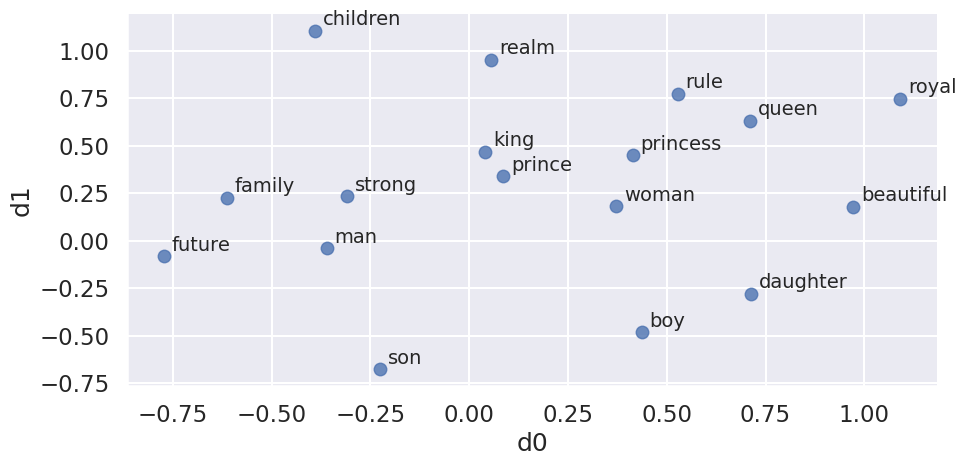

In [34]:
# Visualise the new embeddings
sns.lmplot(data=embedding2, x='d0', y='d1', fit_reg=False, aspect=2)
for token, vector in embedding2.iterrows():
    plt.gca().text(vector['d0']+.02, vector['d1']+.03, str(token),
                   size=14)
plt.tight_layout()

In [35]:
# Save the embeddings and load it with Gensim and do checks
with open('embedding2.txt' ,'w') as text_file:
    text_file.write(f'{n_vocabulary} {dimension}\n')
    for token, vector in embedding2.iterrows():
        text_file.write(f"{token} {' '.join(map(str, vector))}\n")
text_file.close()

In [36]:
embedding2_loaded = KeyedVectors.load_word2vec_format('embedding2.txt', binary=False)
embedding2_loaded.most_similar(positive=['king'], topn=n)

[('realm', 0.9995501041412354),
 ('prince', 0.9869499206542969),
 ('children', 0.9105312824249268)]

In [ ]:
# When calculating cosine similarity to find similar words, we used scipy this time. This approach matches with Gensim’s result except for the floating-point precision error.